In [1]:
import numpy as np 
import matplotlib.pyplot as plt
def verify(src_data, dec_data):
    """
    Compare the decompressed data with original data
    :param src_data: original data, numpy array
    :param dec_data: decompressed data, numpy array
    :return: max_diff, psnr, nrmse
    """
    data_range = np.max(src_data) - np.min(src_data)
    diff = src_data - dec_data
    max_diff = np.max(abs(diff))
    # print("abs err={:.8G}".format(max_diff))
    mse = np.mean(diff ** 2)
    nrmse = np.sqrt(mse) / data_range
    psnr = 20 * np.log10(data_range) - 10 * np.log10(mse)
    return  psnr
import ctypes 
def qcatssim(orig:np.ndarray[np.float32], decompressed:np.ndarray[np.float32]):
    dims = np.array(orig.shape)[::-1]
    # print(dims)
    lib = ctypes.CDLL('/home/pji228/workspace/git/draft/artifact/compress_scripts/aramco_ssim/qcatssim_py.dylib')
    lib.calculateSSIM.restype = ctypes.c_double
    lib.calculateSSIM.argtypes = [np.ctypeslib.ndpointer(dtype=np.float32),
                              np.ctypeslib.ndpointer(dtype=np.float32),
                              np.ctypeslib.ndpointer(dtype=np.int32),
                              ctypes.c_int]
    result =lib.calculateSSIM(
        orig, 
        decompressed,
        dims.astype(np.int32), 
        ctypes.c_int(dims.size))
    return result 

In [2]:
orig = np.fromfile("/project/xli281_uksr/pjiao/data/miranda/velocityx.f32", dtype=np.float32).reshape(256,384,384)


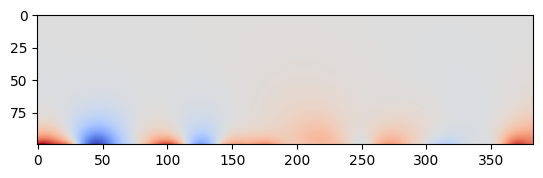

In [17]:
plt.imshow(orig[0:100,0:-1,0], cmap='coolwarm') 

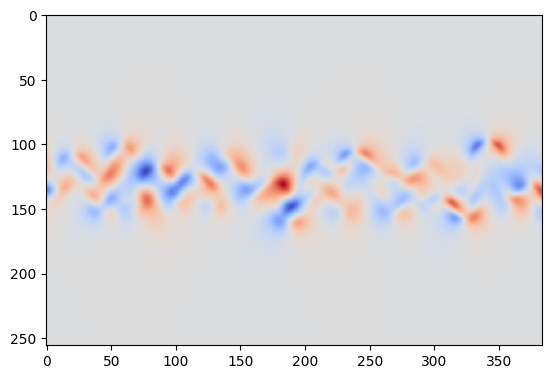

In [74]:
plt.imshow(orig[:,0,:], cmap='coolwarm') 

In [35]:
import os
x1 = 100
x2 = 160 
roi_data = orig[x1:x2,:,:]
shape1= roi_data.shape[0]
roi_data.astype(np.float32).tofile("roi_data.f32")
eb = 0.001
command_line = f"/scratch/pji228/gittmp/posterization_mitigation/build/test/test_quantize_and_edt  \
                 3 {shape1} 384 384 roi_data.f32 {eb} roi_data.f32.dec roi_data.f32.dec.compensated_data.f32"
os.system(command_line)

max: 2.297243, min: -2.214255
relative eb: 0.001000
absolute eb: 0.004511
Min=-2.2142553329467773438, Max=2.2972428798675537109, range=4.5114982128143310547
Max absolute error = 0.0045
Max relative error = 0.001
Max pw relative error = 1
PSNR = 64.770563, NRMSE= 0.0005773934512
normError = 7.748176, normErr_norm = 0.006202
acEff=0.999981
SSE=60.034236
MSE=0.000007
SSIM = 0.999589
aux time = 0.000009 
cache line allocation time = 0.000007
edt total time = 0.995779
edt time = 0.9486318130 
distance time = 0.0468341
aux time = 0.000017 
cache line allocation time = 0.000004
edt time = 1.02898
compensation map size = 8847360
compensation time = 2.6926
Min=-2.2142553329467773438, Max=2.2972428798675537109, range=4.5114982128143310547
Max absolute error = 0.0085
Max relative error = 0.0019
Max pw relative error = 5.9E+02
PSNR = 64.789198, NRMSE= 0.0005761560074
normError = 7.731571, normErr_norm = 0.006188
acEff=0.999981
SSE=59.777186
MSE=0.000007
SSIM = 0.999628


0

Text(0.5, 0.98, 'ROI x1=100 - 160')

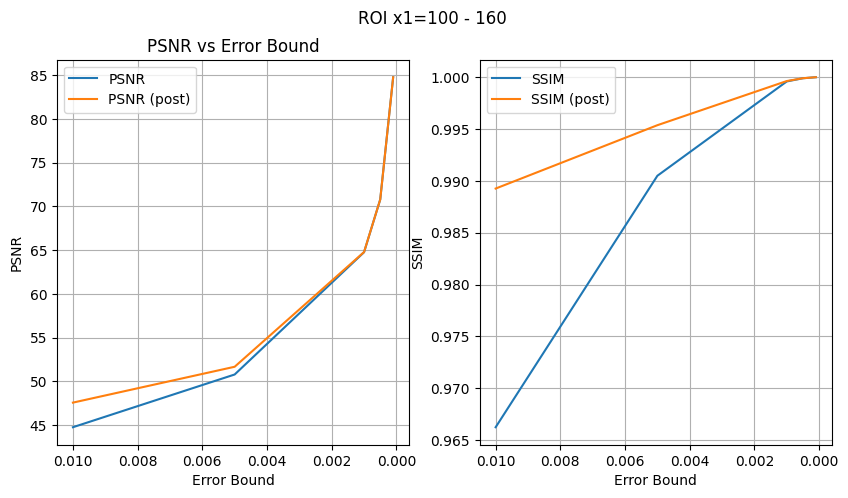

In [62]:
ebs = [0.0001, 0.0005, 0.001, 0.005, 0.01]
psnrs = [84.771945, 70.791747,64.770563,50.792931, 44.767258] 
post_psnrs = [84.771890 , 70.793140,64.789198,51.677589,47.579063]
ssim =[0.999996,0.999897,0.999589,0.990490,0.966233 ]
post_ssim = [0.999996, 0.999899,0.999628,0.995368,0.989257 ] 
figs, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(ebs, psnrs, label='PSNR')
axs[0].plot(ebs, post_psnrs, label='PSNR (post)')
axs[0].set_xlabel('Error Bound')
axs[0].set_ylabel('PSNR')
axs[0].legend()
axs[0].set_title('PSNR vs Error Bound')
axs[0].invert_xaxis()
axs[1].plot(ebs, ssim, label='SSIM')
axs[1].plot(ebs, post_ssim, label='SSIM (post)')
axs[1].set_xlabel('Error Bound')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].invert_xaxis()
axs[0].grid()
axs[1].grid()
plt.suptitle('ROI x1=100 - 160')

In [ ]:
import os
x1 = 0
x2 = 100 
roi_data = orig[x1:x2,:,:]
shape1= roi_data.shape[0]
roi_data.astype(np.float32).tofile("roi_data.f32")
eb = 0.005
command_line = f"/scratch/pji228/gittmp/posterization_mitigation/build/test/test_quantize_and_edt  \
                 3 {shape1} 384 384 roi_data.f32 {eb} roi_data.f32.dec roi_data.f32.dec.compensated_data.f32"
os.system(command_line)

Text(0.5, 0.98, 'ROI x = 0-100')

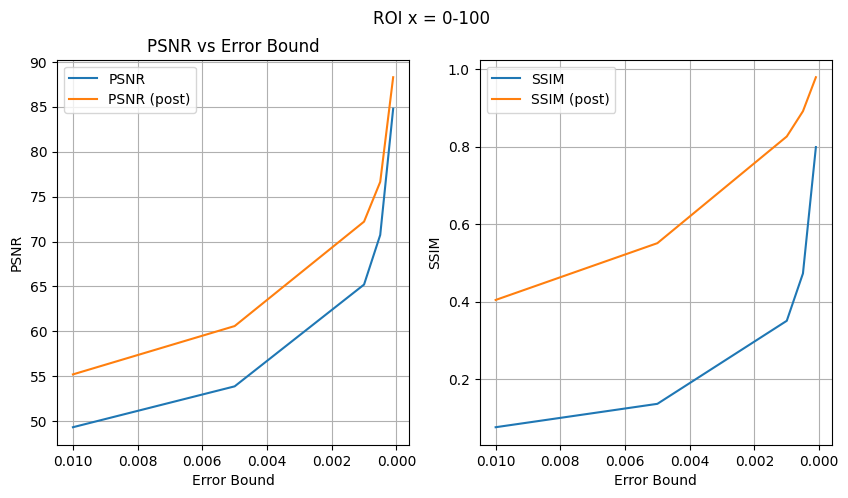

In [63]:
ebs = [0.0001, 0.0005, 0.001, 0.005, 0.01]
psnrs = [84.779506,70.734187, 65.213775,53.888710, 49.341307] 
post_psnrs = [88.282004, 76.637125, 72.214452,60.595876,55.217835 ]
ssim =[ 0.798861, 0.472589, 0.350414,0.136005,0.075625 ]
post_ssim = [ 0.979238 , 0.891477 ,0.826248,0.550826,0.404167] 
figs, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(ebs, psnrs, label='PSNR')
axs[0].plot(ebs, post_psnrs, label='PSNR (post)')
axs[0].set_xlabel('Error Bound')
axs[0].set_ylabel('PSNR')
axs[0].legend()
axs[0].set_title('PSNR vs Error Bound')
axs[0].invert_xaxis()
axs[1].plot(ebs, ssim, label='SSIM')
axs[1].plot(ebs, post_ssim, label='SSIM (post)')
axs[1].set_xlabel('Error Bound')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].invert_xaxis()
axs[0].grid()
axs[1].grid()
plt.suptitle('ROI x = 0-100')


In [ ]:
import os
x1 = 160
x2 = -1 
roi_data = orig[x1:x2,:,:]
shape1= roi_data.shape[0]
roi_data.astype(np.float32).tofile("roi_data.f32")
eb = 0.01
command_line = f"/scratch/pji228/gittmp/posterization_mitigation/build/test/test_quantize_and_edt  \
                 3 {shape1} 384 384 roi_data.f32 {eb} roi_data.f32.dec roi_data.f32.dec.compensated_data.f32"
os.system(command_line)

Text(0.5, 0.98, 'ROI x = 160:256')

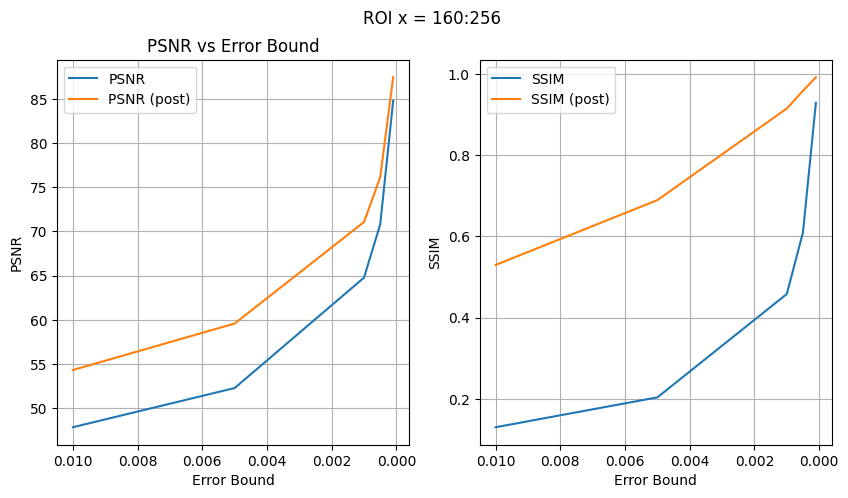

In [65]:
ebs = [0.0001, 0.0005, 0.001, 0.005, 0.01]
psnrs = [84.769152, 70.800222, 64.766034, 52.271900,47.838482 ] 
post_psnrs = [87.440045, 76.131576,  71.059536,59.568244,54.314121 ]
ssim =[ 0.929251, 0.609612, 0.458095, 0.203467,0.129943 ]
post_ssim = [0.992183,  0.958607,0.915039,0.689441, 0.529703] 
figs, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(ebs, psnrs, label='PSNR')
axs[0].plot(ebs, post_psnrs, label='PSNR (post)')
axs[0].set_xlabel('Error Bound')
axs[0].set_ylabel('PSNR')
axs[0].legend()
axs[0].set_title('PSNR vs Error Bound')
axs[0].invert_xaxis()
axs[1].plot(ebs, ssim, label='SSIM')
axs[1].plot(ebs, post_ssim, label='SSIM (post)')
axs[1].set_xlabel('Error Bound')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].invert_xaxis()
axs[0].grid()
axs[1].grid()
plt.suptitle('ROI x = 160:256')

In [ ]:
import os
x1 = 0
x2 = 256 
roi_data = orig[x1:x2,:,:]
shape1= roi_data.shape[0]
roi_data.astype(np.float32).tofile("roi_data.f32")
eb = 0.01
command_line = f"/scratch/pji228/gittmp/posterization_mitigation/build/test/test_quantize_and_edt  \
                 3 {shape1} 384 384 roi_data.f32 {eb} roi_data.f32.dec roi_data.f32.dec.compensated_data.f32 32"
os.system(command_line)

Text(0.5, 0.98, 'Whole Domain')

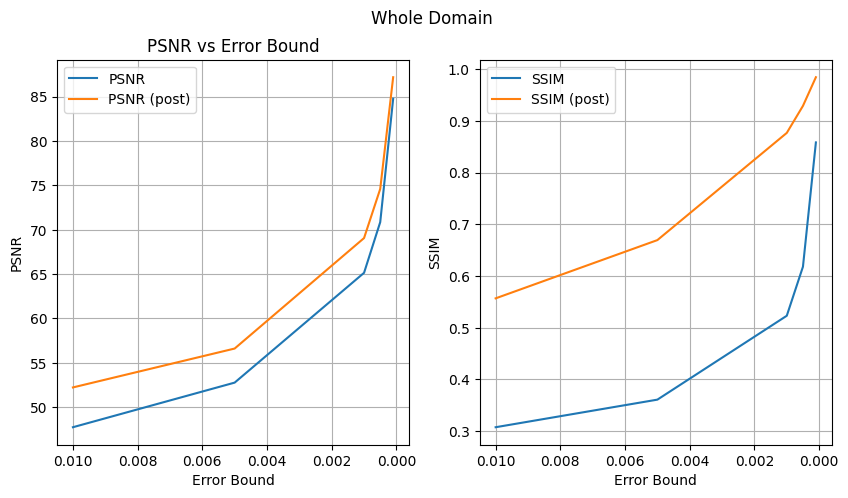

In [73]:
ebs = [0.0001, 0.0005, 0.001, 0.005, 0.01]
psnrs = [84.773688,70.858707, 65.146515, 52.767548,47.738627 ] 
post_psnrs = [87.197601,74.606451, 69.063744, 56.609003, 52.224016 ]
ssim =[  0.858306,0.618014, 0.523204, 0.361037 ,0.307720 ]
post_ssim = [0.984301,0.928904, 0.876673, 0.669451 , 0.556851] 
figs, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(ebs, psnrs, label='PSNR')
axs[0].plot(ebs, post_psnrs, label='PSNR (post)')
axs[0].set_xlabel('Error Bound')
axs[0].set_ylabel('PSNR')
axs[0].legend()
axs[0].set_title('PSNR vs Error Bound')
axs[0].invert_xaxis()
axs[1].plot(ebs, ssim, label='SSIM')
axs[1].plot(ebs, post_ssim, label='SSIM (post)')
axs[1].set_xlabel('Error Bound')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].invert_xaxis()
axs[0].grid()
axs[1].grid()
plt.suptitle('Whole Domain') 